In [1]:
import random
import os
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import multiprocessing as mp

from tqdm import tqdm
from itertools import cycle

In [37]:
#### TO DO
# 1) Change traces_dict format to [[edges list], inode, call_depth]

In [2]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    use_columns = list(range(9)) # change to 9 if using casper
    df = pd.read_csv(file,delimiter=',', usecols=use_columns)
    return df

def extract_traceid_rows(df, tid):
    '''
    Returns a list of rpc calls in tid
    '''
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls


def df_to_trace_edges_dict(df):
    '''
    Args: Alibaba traces dataframe
    Return: Dict, Key:tid, Val:list of edges
    '''
    tids_list = df['traceid'].unique().tolist()
    traces_edges = {}
    for i in tqdm(range(len(tids_list))):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        t_edges = [] # list of edges of trace
        for call in tid_calls:
            t_edges.append([call.um, call.dm])
        traces_edges[tids_list[i]] = t_edges
    return traces_edges

def get_valid_traces(df):
    '''
    Trace is valid only if Initial node details are available.
    Discard trace if initial node details not available.
    Modifies df in place.
    Args: List of tids in original trace.
    Returns: List of valid tids.
    '''
    tids_list = df['traceid'].unique().tolist()
    valid_tids_list = []
    invalid_tids = []
    for i in tqdm(range(len(tids_list)), desc='Getting valid tids...'):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        initial_node = ''
        for call in tid_calls:
            if call.rpcid == "0":
                initial_node = call.dm
                valid_tids_list.append(tids_list[i])
        if initial_node == '':
            invalid_tids.append(tids_list[i])
            # df = df[df['traceid'] != tids_list[i]]
            
    # Remove all invalid tid rows
    print('Num Valid tids: ', len(valid_tids_list))
    print('Num Invalid tids: ',len(invalid_tids))
    df = df[~df['traceid'].isin(invalid_tids)]
    return valid_tids_list, df

def get_call_depth(rpc_id):
    if rpc_id == "0":
        return 1
    else:
        call_depth = 0
        for i in rpc_id:
            if i == ".":
                call_depth += 1
    return call_depth

def save_dict_as_pkl(traces_dict, file_name):
    with open(file_name+'.pkl', 'wb') as pkl_file:
        pickle.dump(traces_dict, pkl_file)

def pkl_to_dict(file_path):
    with open(file_path, 'rb') as pkl_file:
        T_prime = pickle.load(pkl_file)
    return T_prime

def get_top_n_nodes(node_dets_dict, n, node_type):
    if node_type == 'db':
        nodes = [(node, n_nis) for node, (n_nis, n_type) in node_dets_dict.items() if n_type == 'db']
    else:
        nodes = [(node, n_nis) for node, (n_nis, n_type) in node_dets_dict.items() if n_type != 'db']

    sorted_nodes = sorted(nodes, key=lambda item: item[1], reverse=True)
    return [node for node, _ in sorted_nodes[:n]]

def correct_unknown_node_err(df):
    '''
    Replaces '(?)' with a random node
    # '''
    # sf_nodes_list = df.loc[(df['rpctype'] == 'db') & (df['dm'] != '(?)'), 'dm'].unique().tolist()
    # sl_nodes_list = df.loc[(df['rpctype'] != 'db') & (df['dm'] != '(?)'), 'dm'].unique().tolist()

    node_dets_dict = pkl_to_dict('node_and_trace_details/node_details_data.pkl')
    sf_nodes_list = get_top_n_nodes(node_dets_dict, 200, 'db')
    sl_nodes_list = get_top_n_nodes(node_dets_dict, 500, 'sl')

    rand_sf_nids = random.sample(sf_nodes_list, len(sf_nodes_list))
    rand_sl_nids = random.sample(sl_nodes_list, int(len(sl_nodes_list)/2))

    # Randomly assign nodeids to unknown nodes
    um_mask = df['um'] == '(?)'
    dm_mask = df['dm'] == '(?)'
    sf_mask = df['rpctype'] == 'db'
    sl_mask = df['rpctype'] != 'db'

    # Replace UM unknow nodes
    df.loc[um_mask & sf_mask, 'um'] = np.random.choice(rand_sf_nids)
    df.loc[um_mask & sl_mask, 'um'] = np.random.choice(rand_sl_nids)
    # Replace DM unknow nodes
    df.loc[dm_mask & sf_mask, 'dm'] = np.random.choice(rand_sf_nids)
    df.loc[dm_mask & sl_mask, 'dm'] = np.random.choice(rand_sl_nids)

    return df

def calc_graph_depth(G, initial_node):
    def dfs(node, visited, stack):
        # Using stack to avoid cycles
        if node in stack:
            return 0
        if node in visited:
            return visited[node]
        stack.add(node)
        max_depth = 0
        for neighbour in G.successors(node):
            depth = dfs(neighbour, visited, stack)
            max_depth = max(max_depth, depth)
        stack.remove(node)
        visited[node] = max_depth + 1
        
        return visited[node]
    
    visited = {}
    stack = set()

    return dfs(initial_node, visited, stack)

def find_inode_and_graph_depth(G):
    max_depth = -1
    node_with_max_depth = ''

    for node in G.nodes():
        depth = calc_graph_depth(G, node)
        if depth > max_depth:
            max_depth = depth
            node_with_max_depth = node
    return node_with_max_depth, max_depth

def buildg_from_tracesdict(traces_dict):
    full_graph_edge_list = []
    for edge_list in traces_dict.values():
        full_graph_edge_list.extend(edge_list)
    G = nx.DiGraph()
    G.add_edges_from(full_graph_edge_list)
    return G

In [14]:
# # '''
# # Clean & Store alibaba trace
# # Extract valid tids and replace unknown nodes.
# # '''

# # #<UNCOMMENT IF NEED TO CLEAN DATASET>

# # Extract to dataframe
# df = pd.DataFrame()
# data_parts_path = "./trace_data/"
# for filename in os.listdir(data_parts_path):
#     temp_df = csv_to_df(data_parts_path + filename)
#     df = pd.concat([df, temp_df], ignore_index = True)

# # # Extract all valid tids (REMOVE IF NECESSARY)
# # tids_list, df = get_valid_traces(df)
# tids_list = df['traceid'].unique()
# # Replace Unknown nodes 
# df = correct_unknown_node_err(df)

# unique_nodes = list(set(df['um'].unique().tolist() + df['dm'].unique().tolist()))
# num_traces = len(tids_list)
# df.to_csv('casper_rebuild_cleaned.csv', index=False)
# print("Num of tids (traces): ", num_traces)
# print("Num of unique nodes: ", len(unique_nodes))


Num of tids (traces):  260270
Num of unique nodes:  8310


In [3]:
# df = pd.DataFrame()
# data_parts_path = "./trace_data/"
# for filename in os.listdir(data_parts_path):
#     temp_df = csv_to_df(data_parts_path + filename)
#     df = pd.concat([df, temp_df], ignore_index = True)

df = csv_to_df("./casper_rebuild_cleaned.csv")

tids_list = df['traceid'].unique()
num_traces = len(tids_list)
unique_nodes = list(set(df['um'].unique().tolist() + df['dm'].unique().tolist()))
print("Num of tids (traces): ", num_traces)
print("Num of unique nodes: ", len(unique_nodes))

Num of tids (traces):  260270
Num of unique nodes:  8310


In [4]:
'''
NIS calc
Node Metrics: [NIS, type]
'''
def chunk_df(dfs):
    '''
    Chunk dataframe into 100 chunks
    '''
    chunk_size = int(len(dfs)/100)
    df_chunks = []
    for i in range(0, len(dfs), chunk_size):
        df_chunks.append(dfs[i:i+chunk_size])
    return df_chunks

#The df has 33M rows, but we give only 33M/100 = 33K rows for sampling
def process_dfchunk(df_chunk):
    nis_dict = {} # nid: [traceids node is part of]
    node_details_dict = {} # Create Node details dict, nid: [nis, type]
    for row in df_chunk.itertuples():
        um_node = row.um
        dm_node = row.dm

        # Update node type dict for dm_node
        if dm_node not in node_details_dict:
            if row.rpctype == 'db':
                sfsl_type = 'db'
            else:
                sfsl_type = 'sl'
            node_details_dict[dm_node] = [0, sfsl_type]

        # Update nis dict for um_node
        if um_node in nis_dict:
            if row.traceid not in nis_dict[um_node]:
                nis_dict[um_node].append(row.traceid)
        else:
            nis_dict[um_node] = [row.traceid]
        # Update nis dict for dm_node
        if dm_node in nis_dict:
            if row.traceid not in nis_dict[dm_node]:
                nis_dict[dm_node].append(row.traceid)
        else:
            nis_dict[dm_node] = [row.traceid]
    return nis_dict, node_details_dict

def aggregate_node_dicts(nis_dict_list, nd_dict_list, num_traces):
    '''
    Aggregate NIS and node details dictionaries from all chunks
    '''
    # NIS dict Aggregation
    nis_dict = {} # nid: [nis]
    for chunk_nis_dict in tqdm(nis_dict_list): 
        for node, traces in chunk_nis_dict.items():
            if node not in nis_dict:
                nis_dict[node] = traces
            else:
                nis_dict[node].extend(traces)
    for nid in nis_dict:
        nis_dict[nid] = list(set(nis_dict[nid]))
        nis = len(nis_dict[nid])/num_traces
        nis_dict[nid] = [round(nis,7)]
    
    # Node details dict Aggregation
    node_details_dict = {} # nid: [nis, type]
    for chunk_nd_dict in tqdm(nd_dict_list):
        for node, details in chunk_nd_dict.items():
            if node not in node_details_dict:
                if node in nis_dict:
                    node_nis = nis_dict[node][0]
                else:
                    # print('Node not in nis dict')
                    node_nis = 0.02
                node_type = details[1]
                node_details_dict[node] = [node_nis, node_type]
    return nis_dict, node_details_dict

def parallel_process(df_chunks, num_traces):
    with mp.Pool(processes=100) as pool:
        results = pool.map(process_dfchunk, df_chunks)
    nis_dict_list, nd_dict_list = zip(*results)
    return aggregate_node_dicts(nis_dict_list, nd_dict_list, num_traces)

# replace traceid list with NIS
# num_traces = 4439 ### TO BE REPLACED

df_chunks = chunk_df(df) # 100 chunks
nis_dict, node_details_dict = parallel_process(df_chunks, num_traces)

save_dict_as_pkl(nis_dict, 'node_and_trace_details/nis_dict')
save_dict_as_pkl(node_details_dict, 'node_and_trace_details/node_details_data')

100%|██████████| 101/101 [00:00<00:00, 3894.54it/s]


In [18]:
print(len(node_details_dict))

8290


In [8]:
'''
Parallel Trace metrics calc
Trace Metrics: [trace_depth, TIS, initial_node, num_sf, num_sl]
'''

def process_trace_chunk(tids_chunk, chunk_id, df, nis_dict):
    local_trace_metrics = {}
    for tid in tids_chunk:
        tid_calls = extract_traceid_rows(df, tid)
        initial_node = ""
        t_edges = []
        t_nodes = []
        t_sf_ctr = 0
        t_sl_ctr = 0
        trace_depth = 0
        for call in tid_calls:
            if call.rpcid != "0":# dont ADD for RPCID 0
                t_edges.append([call.um, call.dm])
                if call.um not in t_nodes:
                    t_nodes.append(call.um)
                if call.dm not in t_nodes:
                    t_nodes.append(call.dm)
            if call.rpctype == "db":
                t_sf_ctr += 1
            else:
                t_sl_ctr += 1

        # Initial node & trace depth
        G = nx.DiGraph()
        G.add_edges_from(t_edges)
        initial_node, trace_depth = find_inode_and_graph_depth(G)

        # TIS calculation
        tis = 0
        for node in t_nodes:
            try:
                nis_temp = nis_dict[node][0]
            except:
                print("nis miss")
                nis_temp = 0
            tis += nis_temp
        tis = tis/len(t_nodes)

        local_trace_metrics[tid] = [trace_depth, tis, initial_node,\
                                     t_sf_ctr, t_sl_ctr]
    save_dict_as_pkl(local_trace_metrics, f"output_data/local_trace_metrics_{chunk_id}")
    return local_trace_metrics

def aggregate_trace_met_dicts(trace_metrics_dicts):
    print("Aggregating trace metrics dicts...")
    trace_met_dict = {}
    for t_met_dict in trace_metrics_dicts:
        trace_met_dict.update(t_met_dict)
    return trace_met_dict

def parallel_trace_metrics(tids_chunks, df, nis_dict):
    with mp.Pool(processes=50) as pool:
        list_of_trace_metrics_dicts = \
            pool.starmap(process_trace_chunk,tqdm([(tids_chunk, i, df, nis_dict) for\
                                                   i, tids_chunk in enumerate(tids_chunks)]))
    
    trace_met_dict = aggregate_trace_met_dicts(list_of_trace_metrics_dicts)
    return trace_met_dict

# Chunk trace ids
num_chunks = 50
chunk_size = len(tids_list) // num_chunks
print(chunk_size)
tids_chunks = [tids_list[i:i+chunk_size] for i in range(0, len(tids_list), chunk_size)]

trace_met_dict = parallel_trace_metrics(tids_chunks, df, nis_dict)

# Compute cd_strat_dict based on trace_met_dict
cd_strat_dict = {} # Key: cd, val: [[tid ,tis],...]
for tid in trace_met_dict:
    trace_depth = trace_met_dict[tid][0]
    if trace_depth in cd_strat_dict:
        cd_strat_dict[trace_depth].append([tid, trace_met_dict[tid][1]])
    else:
        cd_strat_dict[trace_depth] = [[tid, trace_met_dict[tid][1]]]

save_dict_as_pkl(trace_met_dict, 'node_and_trace_details/trace_details_data')
print("Trace metrics calculated!")

5205


 98%|█████████▊| 50/51 [04:12<00:05,  5.19s/it]

nis miss
nis miss


100%|██████████| 51/51 [44:23<00:00, 52.23s/it] 


Aggregating trace metrics dicts...
Trace metrics calculated!


In [ ]:
# '''
# Trace metrics calc
# Trace Metrics: [trace_depth, TIS, initial_node, num_sf, num_sl]
# '''

# trace_met_dict = {} # Key: tid, Val: [trace_depth, tis, initial_node, t_sf_ctr, t_sl_ctr]
# cd_strat_dict = {} # dict. key: cd, val: [[tid ,tis],...]
# ini_nodes = []
# check = 0
# for i in tqdm(range(len(tids_list)), desc='Trace Metrics Calculation...'):
#     ctr = 0
#     tid_calls = extract_traceid_rows(df, tids_list[i])
#     initial_node = ""
#     t_edges = [] # list of edges in trace
#     t_nodes = [] # list of nodes in trace
#     t_sf_ctr = 0
#     t_sl_ctr = 0
#     trace_depth = 0
#     for call in tid_calls:
#         if call.rpcid != "0":# dont ADD for RPCID 0
#             t_edges.append([call.um, call.dm])
#             if call.um not in t_nodes:
#                 t_nodes.append(call.um)
#             if call.dm not in t_nodes:
#                 t_nodes.append(call.dm)

#         ### TRACE DEPTH & INODE BASED ON RPCID
#         # call_depth = get_call_depth(call.rpcid) 
#         # if call_depth > trace_depth: # update trace depth
#         #     trace_depth = call_depth
#         # if call.rpcid == "0": # get initial node of trace
#         #     check += 1
#         #     initial_node = call.dm
#         if call.rpctype == "db": # get sf sl node count
#             t_sf_ctr += 1
#         else: 
#             t_sl_ctr += 1

#     # Initial node & trace depth
#     G = nx.DiGraph()
#     G.add_edges_from(t_edges)
#     initial_node, trace_depth = find_inode_and_graph_depth(G)

#     # TIS calculation
#     # for edge in t_edges:
#     #     for node in edge:
#     #         if node not in t_nodes:
#     #             t_nodes.append(node)
    
#     tis = 0
#     for node in t_nodes:
#         nis_temp = nis_dict[node][0]
#         tis += nis_temp 
#     tis = tis/len(t_nodes)

#     # Collecting data for stratification
#     if trace_depth not in cd_strat_dict:
#         cd_strat_dict[trace_depth] = []
#     cd_strat_dict[trace_depth].append([tids_list[i],tis])

#     trace_met_dict[tids_list[i]] = [trace_depth, tis, initial_node, t_sf_ctr, t_sl_ctr]

# # save_dict_as_pkl(trace_met_dict, 'downsampled_graphs/trace_details_data')

In [22]:
'''
Reading dics from saved files
'''
node_dets_dict = pkl_to_dict('node_and_trace_details/node_details_data.pkl')
nis_dict = pkl_to_dict('node_and_trace_details/nis_dict.pkl')
trace_met_dict = pkl_to_dict('node_and_trace_details/trace_details_data.pkl')
# Compute cd_strat_dict based on trace_met_dict
cd_strat_dict = {} # Key: cd, val: [[tid ,tis],...]
for tid in trace_met_dict:
    trace_depth = trace_met_dict[tid][0]
    if trace_depth in cd_strat_dict:
        cd_strat_dict[trace_depth].append([tid, trace_met_dict[tid][1]])
    else:
        cd_strat_dict[trace_depth] = [[tid, trace_met_dict[tid][1]]]

print(len(nis_dict))

8311


In [23]:
'''
Stratification
'''

cd_percent_arr = [] # [valid call depth, % of tids of resp cd]

# Collecting cd percentage in the original trace
for cd in cd_strat_dict:
    percent_t_cd = 100 * (len(cd_strat_dict[cd])/num_traces)
    cd_percent_arr.append([cd, percent_t_cd])
    cd_strat_dict[cd] = sorted(cd_strat_dict[cd], key=lambda x: x[1], reverse=True) # sorting tids based on tis

cd_percent_arr.sort(key=lambda x: x[0])

# Sanity check
res= 0
for i in cd_percent_arr:
    res += i[1]
print(res)

99.99999999999997


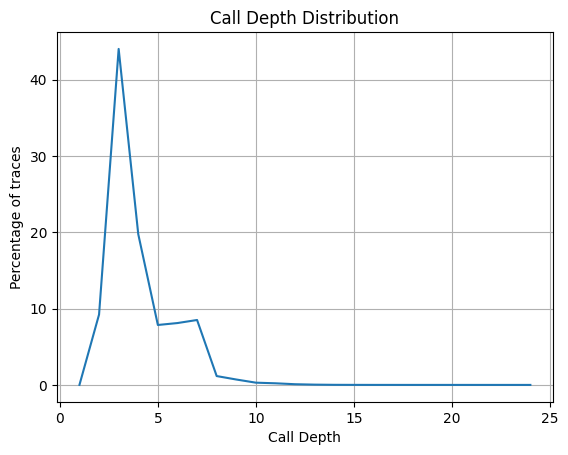

In [24]:
valid_cds = [x[0] for x in cd_percent_arr]
cd_percentages = [x[1] for x in cd_percent_arr]
plt.plot(valid_cds, cd_percentages)
plt.grid(True)
plt.xlabel('Call Depth')
plt.ylabel('Percentage of traces')
plt.title('Call Depth Distribution')
# plt.savefig('figs/cd_distribution_from_rpcids.png')
plt.show()

In [62]:
'''
NIS: Priority Sampling
'''
n = 1500 # Reduced num of nodes (USER DEFINED)
# Sorted nis_dict based on NIS values
nid_nis_arr = [[nid, nis] for nid, nis in nis_dict.items()]
sorted_node_items = sorted(nid_nis_arr, key=lambda item: item[1], reverse=True)
sampled_nodes = []

for node in sorted_node_items[:n]:
    sampled_nodes.append(node[0])
    
print(len(sampled_nodes))
# nid_nis_arr_sorted_dict = dict(sorted_node_items)
# sampled_nodes = list(nid_nis_arr_sorted_dict.keys()[:n]) # List of selected node ids

1500


In [63]:
'''
TIS: Priority Sampling
'''
t_red = 50000 # reduced num of traces (USER DEFINED)
sampled_tids_inter = [] # T_inter

# Priority sampling based on TIS from cd stratas
cd_ctr = 0
for cd in cd_percent_arr: 
    num_traces_to_sample_for_cd = int(t_red * cd[1]/100)
    
    if num_traces_to_sample_for_cd < 1:
        cd_ctr += 1 
        continue
    cd_traces_list = cd_strat_dict[cd[0]]
    cd_priority_sample = cd_traces_list[:num_traces_to_sample_for_cd]
    sampled_cd_tids = [x[0] for x in cd_priority_sample]
    sampled_tids_inter.extend(sampled_cd_tids)
    # print(cd_priority_sample)
print(cd_ctr)

4


In [14]:
# '''
# NODE PRUNING
# Remove all nodes from T_inter that is not in sampled_nodes
# '''

# def cycle_func(A, B, pred_flag):
#     # Cycle through B if it's shorter than A
#     B_cycle = cycle(B)
#     # Create tuples by pairing elements from A with elements from the cycled B
#     if pred_flag == 1: # pred flag is used to check if direction is from pred to succ
#         result = [(a, next(B_cycle)) for a in A]
#     else:
#         result = [(next(B_cycle), a) for a in A]
#     return result


# def remove_node_with_reconnect(G, node):
#     '''
#     Remove given node and check if graph breaks. If yes, connect pred nodes
#     to succ nodes and then remove given node.
#     returns: Updated graph after removing the given node
#     '''
#     num_comp_before_removal = len(list(nx.weakly_connected_components(G)))
#     G_temp = G.copy()
#     G_temp.remove_node(node)
#     num_comp_after_removal = len(list(nx.weakly_connected_components(G_temp)))

#     # If bridge node
#     if num_comp_after_removal > num_comp_before_removal:
#         pred_nodes = list(G.predecessors(node))
#         succ_nodes = list(G.successors(node))
#         if len(succ_nodes) == 0 or len(pred_nodes) == 0: # if leaf node
#             G.remove_node(node)
#             return G
#         if len(pred_nodes) >= len(succ_nodes):
#             edges_to_add = cycle_func(pred_nodes, succ_nodes, 1)
#         else:
#             edges_to_add = cycle_func(succ_nodes, pred_nodes, 0)
#         for edge in edges_to_add:
#             G.add_edge(edge[0], edge[1])
    
#     # If not bridge 
#     G.remove_node(node)

#     return G

# def prune_nodes_testy(sampled_tids_inter, sampled_nodes, df):
#     '''
#     Args: sampled_tids_inter= list of selected trace ids,
#           sampled_nodes= list of selected node ids
#     Returns: two Dicts(original & pruned); Key=tid, Val=list of edges to build tid
#     '''
#     T_prime = {}
#     T_original = {}
#     ctr = 0
#     check_unique_nodes = []
#     nodes_removed_per_trace = []
#     unique_nodes_removed = []

#     for tid in tqdm(sampled_tids_inter):
#         ctr += 1
#         nodes_to_remove = []# get list of nodes to remove in trace
#         tid_calls = extract_traceid_rows(df, tid)
#         t_edges = []
#         for call in tid_calls:
#             t_edges.append([call.um, call.dm])
#             if call.um not in check_unique_nodes:
#                 check_unique_nodes.append(call.um)
#             if call.dm not in check_unique_nodes:
#                 check_unique_nodes.append(call.dm)
            
#         # Build pre-pruned graph
#         G = nx.DiGraph()
#         G.add_edges_from(t_edges)
#         T_original[tid] = t_edges

#         # Handling broken graphs (~40% are broken)
#         num_comp_before_removal = len(list(nx.weakly_connected_components(G)))
#         if num_comp_before_removal > 1:
#             # select the largest component
#             largest_comp = max(nx.weakly_connected_components(G), key=len)
#             G = G.subgraph(largest_comp).copy()

#         for node in G.nodes():
#             if node not in sampled_nodes:
#                 nodes_to_remove.append(node)
        
#         # nodes_to_remove = list(set(nodes_to_remove))
#         nodes_removed_per_trace.append(len(nodes_to_remove))

#         # Do node pruning
#         for node in nodes_to_remove:
#             if node in G:
#                 if node not in unique_nodes_removed:
#                     unique_nodes_removed.append(node)
#                 G = remove_node_with_reconnect(G, node)

#         # edges in pruned trace 
#         all_edges = list(G.edges())
#         T_prime[tid] = all_edges

#     print('Sampled num of nodes: ', len(sampled_nodes))
#     print('Sampled traces count: ', len(sampled_tids_inter))
#     print('Unique nodes in selected tids: ', len(check_unique_nodes))
#     print('Unique nodes removed: ', len(unique_nodes_removed))
#     print('Total nodes removed(sum:max:min): ', sum(nodes_removed_per_trace), ':', max(nodes_removed_per_trace), ':', min(nodes_removed_per_trace))
#     # print('Number of broken traces: ', len(broken_traces))
#     return T_prime, T_original

# def parallel_pruning(sampled_tids_chunks, df, nis_dict):
#     with mp.Pool(processes=50) as pool:
#         list_of_trace_metrics_dicts = \
#             pool.starmap(process_trace_chunk,tqdm([(tids_chunk, i, df, nis_dict) for\
#                                                    i, tids_chunk in enumerate(tids_chunks)]))
    
#     trace_met_dict = aggregate_trace_met_dicts(list_of_trace_metrics_dicts)
#     return trace_met_dict


39991


In [64]:
'''
NODE PRUNING
Remove all nodes from T_inter that is not in sampled_nodes
'''

def cycle_func(A, B, pred_flag):
    # Cycle through B if it's shorter than A
    B_cycle = cycle(B)
    # Create tuples by pairing elements from A with elements from the cycled B
    if pred_flag == 1: # pred flag is used to check if direction is from pred to succ
        result = [(a, next(B_cycle)) for a in A]
    else:
        result = [(next(B_cycle), a) for a in A]
    return result


def remove_node_with_reconnect(G, node):
    '''
    Remove given node and check if graph breaks. If yes, connect pred nodes
    to succ nodes and then remove given node.
    returns: Updated graph after removing the given node
    '''
    num_comp_before_removal = len(list(nx.weakly_connected_components(G)))
    G_temp = G.copy()
    G_temp.remove_node(node)
    num_comp_after_removal = len(list(nx.weakly_connected_components(G_temp)))

    # If bridge node
    if num_comp_after_removal > num_comp_before_removal:
        pred_nodes = list(G.predecessors(node))
        succ_nodes = list(G.successors(node))
        if len(succ_nodes) == 0 or len(pred_nodes) == 0: # if leaf node
            G.remove_node(node)
            return G
        if len(pred_nodes) >= len(succ_nodes):
            edges_to_add = cycle_func(pred_nodes, succ_nodes, 1)
        else:
            edges_to_add = cycle_func(succ_nodes, pred_nodes, 0)
        for edge in edges_to_add:
            G.add_edge(edge[0], edge[1])
    
    # If not bridge 
    G.remove_node(node)

    return G

def prune_nodes_tid_chunk(sampled_tids_chunk, sampled_nodes, df):
    '''
    Args: sampled_tids_chunk= list of selected trace ids,
          sampled_nodes= list of selected node ids
    Returns: two Dicts(original & pruned); Key=tid, Val=list of edges to build tid
    '''
    T_prime = {}
    T_original = {}
    check_unique_nodes = []
    nodes_removed_per_trace = []
    unique_nodes_removed = []

    for tid in tqdm(sampled_tids_chunk):
        nodes_to_remove = []# get list of nodes to remove in trace
        tid_calls = extract_traceid_rows(df, tid)
        t_edges = []
        for call in tid_calls:
            t_edges.append([call.um, call.dm])
            if call.um not in check_unique_nodes:
                check_unique_nodes.append(call.um)
            if call.dm not in check_unique_nodes:
                check_unique_nodes.append(call.dm)
            
        # Build pre-pruned graph
        G = nx.DiGraph()
        G.add_edges_from(t_edges)
        T_original[tid] = t_edges

        # Handling broken graphs (~40% are broken)
        num_comp_before_removal = len(list(nx.weakly_connected_components(G)))
        if num_comp_before_removal > 1:
            # select the largest component
            largest_comp = max(nx.weakly_connected_components(G), key=len)
            G = G.subgraph(largest_comp).copy()

        for node in G.nodes():
            if node not in sampled_nodes:
                nodes_to_remove.append(node)
        
        # nodes_to_remove = list(set(nodes_to_remove))
        nodes_removed_per_trace.append(len(nodes_to_remove))

        # Do node pruning
        for node in nodes_to_remove:
            if node in G:
                if node not in unique_nodes_removed:
                    unique_nodes_removed.append(node)
                G = remove_node_with_reconnect(G, node)

        # edges in pruned trace 
        all_edges = list(G.edges())
        T_prime[tid] = all_edges

    return T_prime, T_original

def parallel_pruning(sampled_tids_chunks, df, sampled_nodes):
    with mp.Pool(processes=50) as pool:
        results = \
            pool.starmap(prune_nodes_tid_chunk,\
                [(sampled_tids_chunks[i],sampled_nodes, df) for i in range(len(sampled_tids_chunks))])
        T_prime_list, T_original_list = zip(*results)
    return T_prime_list, T_original_list

def aggregate_pruned_traces(T_prime_list, T_original_list):
    print("Aggregating pruned traces...")
    T_prime = {}
    T_original = {}
    for t in T_prime_list:
        T_prime.update(t)
    for t in T_original_list:
        T_original.update(t)
    return T_prime, T_original
    
# Chunk sampled trace ids
num_chunks = 50
chunk_size = len(sampled_tids_inter) // num_chunks
sampled_tids_chunks = [sampled_tids_inter[i:i+chunk_size]\
               for i in range(0, len(sampled_tids_inter), chunk_size)]

T_prime_list, T_original_list = parallel_pruning(sampled_tids_chunks, df, sampled_nodes)
T_prime, T_original = aggregate_pruned_traces(T_prime_list, T_original_list)

save_dict_as_pkl(T_prime, 'downsampled_graphs/prime/700nodes_50ktraces(12x)')

100%|██████████| 999/999 [08:22<00:00,  1.99it/s]


Aggregating pruned traces...


In [ ]:
# # Pruning Check
# T_prime, T_original = prune_nodes_testy(sampled_tids_inter, sampled_nodes, df)
# # print(len(sampled_nodes))
# save_dict_as_pkl(T_prime, 'downsampled_graphs/prime/4000nodes_40ktraces')

In [66]:
G_prime = buildg_from_tracesdict(T_prime)
G_original = buildg_from_tracesdict(T_original)
print('Nodes in Selected traces: ', len(G_original.nodes()))
print('Nodes in Sampled Graph: ', len(G_prime.nodes()))

Nodes in Selected traces:  1168
Nodes in Sampled Graph:  705


### Naive Sampling 

In [6]:
T_original = df_to_trace_edges_dict(df)

100%|██████████| 8937/8937 [02:42<00:00, 55.07it/s]


In [17]:
'''
NAIVE SAMPLING
Naive Approach.
Select traces with num nodes < n, prune nodes if more than n.
Radomly assign nids(from n nids) to each node in the trace.
'''

def truncate_to_n_nodes(G, n):
    if len(G.nodes()) <= n:
        return G
    random_nodes = random.sample(G.nodes(), n)
    truncated_graph = G.subgraph(random_nodes).copy()
    return truncated_graph

def remap_graph_nodes(G, new_nid_map):
    # create mapping to new nids
    G = nx.relabel_nodes(G, new_nid_map)
    return G
    

def naive_sampling(traces_dict, num_nodes, num_traces):
    '''
    Args: trace_dict= original edges, num_nodes, num_traces
    Return: Dict= Key: tid, Val:[[edges list], inode, call_depth]
    '''
    T_prime = {}
    # Create new nid map= Key:old_nid, Val:new_nid
    new_nid_map = {}
    G = buildg_from_tracesdict(traces_dict)
    new_nids_list = list(range(1, num_nodes+1))
    for node in G.nodes():
        new_nid_map[node] = random.choice(new_nids_list)

    # Select the num of traces mentioned
    random_tids = random.sample(list(traces_dict.keys()), num_traces)
    new_traces_dict = {tid: traces_dict[tid] for tid in random_tids}

    # Build trace graphs
    for tid, edge_list in new_traces_dict.items():
        G = nx.DiGraph()
        G.add_edges_from(edge_list)
        # Truncate graphs
        G_trunc = truncate_to_n_nodes(G, num_nodes)
        # Remap to new nids
        G_trunc_remapped = remap_graph_nodes(G_trunc, new_nid_map)
        t_edges = list(G_trunc_remapped.edges())
        initial_node, trace_depth = find_inode_and_graph_depth(G_trunc_remapped)
        T_prime[tid] = t_edges
        
    
    return T_prime


T_prime = naive_sampling(T_original, 200, 4500)


/tmp/user/1348/ipykernel_2085960/2180209444.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(G.nodes(), n)


In [18]:
G_prime = buildg_from_tracesdict(T_prime)
G_original = buildg_from_tracesdict(T_original)
print('Nodes in Selected traces: ', len(G_original.nodes()))
print('Nodes in Sampled Graph: ', len(G_prime.nodes()))

Nodes in Selected traces:  3987
Nodes in Sampled Graph:  200


In [19]:
save_dict_as_pkl(T_prime, 'naive_sampled_graphs/200nodes_4500traces')